<a href="https://colab.research.google.com/github/arnisafazla/CS490/blob/main/CS_490_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/CS490/CS490-Senior-Research-Project

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [3]:
! git pull

Already up to date.


In [ ]:
!git config --global user.email "arnisa.fazla@ug.bilkent.edu.tr"
!git config --global user.name "arnisafazla"
! git add .

In [ ]:
! git commit -m 'tran'

In [ ]:
! git rm ./models/__pycache__/ -r

fatal: pathspec './models/__pycache__/' did not match any files


In [ ]:
! git check-ignore -v __pycache__/

.gitignore:1:__pycache__	__pycache__/


In [ ]:
! echo 'models/__pycache__' >> .gitignore

In [ ]:
! git add models/
! git add tools.py

In [ ]:
! git push origin main

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 298 bytes | 74.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/arnisafazla/CS490-Senior-Research-Project.git
   7bd3480..8eb8ab0  main -> main


In [3]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

# path to the cloned repo
main_dir = '/content/drive/MyDrive/CS490/CS490-Senior-Research-Project'  
# path to the dataset folder
dataset_dir = '/content/drive/MyDrive/CS490/dataset'
%cd {main_dir}
sys.path.insert(0,main_dir)
sys.path.insert(0,'/content/drive/MyDrive/CS490')
from dataset import Dataset
from models.critic_models.LSTM_critic import define_critic
from models.critic_models.projection_critic import define_projection_critic
from models.generator_models.norm_generator import define_norm_generator
from models.Base_WGAN import Base_WGAN

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [202]:
%cd /content/drive/MyDrive/CS490/models
! mkdir models_smoothened_data

/content/drive/MyDrive/CS490/models


In [4]:
# path is the path to the dataset
dataset = Dataset(["anger", "joy", "fear", "neutral", "sadness", "pride"], path=dataset_dir, step_size=10, frames=200)
# dataset = Dataset(["anger"], path=dataset_dir, step_size=10, frames=400)

anger


100%|██████████| 65/65 [00:09<00:00,  6.86it/s]


joy


100%|██████████| 29/29 [00:05<00:00,  5.08it/s]


fear


100%|██████████| 32/32 [00:05<00:00,  6.34it/s]


neutral


100%|██████████| 84/84 [00:10<00:00,  7.88it/s]


sadness


100%|██████████| 46/46 [00:06<00:00,  6.73it/s]


pride


100%|██████████| 24/24 [00:04<00:00,  5.54it/s]


In [29]:
! rm -rf /content/drive/MyDrive/CS490/models/models_smoothened_data/WGAN_layer_norm2022.02.24-19:36:46

In [5]:
Dataset.balance(dataset)

No. of samples in each class will be:  1114


In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
    
def define_norm_generator(config):
  init = keras.initializers.RandomNormal(stddev=config['init_std'])
  in_label = layers.Input(shape=(1,), name='label_input')
  if config['generator_batch_norm'] or config['generator_layer_norm']:
    li = in_label
  else:
    li = layers.CategoryEncoding(num_tokens=config['n_classes'], output_mode="one_hot", name='one-hot')(in_label)
  li = layers.RepeatVector(config['in_shape'][0], name='repeat')(li)

  in_lat = layers.Input(shape=(config['latent_dim'],), name='seq_input')
  lat = layers.Dense( config['in_shape'][0] * config['in_shape'][1], name='lat_upsample')(in_lat)
  lat = layers.Reshape((config['in_shape'][0], config['in_shape'][1]))(lat)
  # merge = keras.layers.Concatenate(name='concatenate', axis=2)([li, lat])

  hidden1 = layers.LSTM(config['in_shape'][1]*2, name='LSTM1', return_sequences=True, kernel_initializer=init)(lat)
  merged = layers.Concatenate(axis=2, name='concatenate')([hidden1, li])
  if config['generator_batch_norm']:
    merged = layers.TimeDistributed(ConditionalBatchNorm(n_classes=config['n_classes'], name='conditional_batch_norm'))(merged)
  elif config['generator_layer_norm']:
    merged = layers.TimeDistributed(ConditionalLayerNorm(n_classes=config['n_classes'], name='conditional_layer_norm'))(merged)
  elif config['generator_layer_norm_plus']:
    merged = layers.TimeDistributed(ConditionalLayerNormPlus(n_classes=config['n_classes'], name='conditional_layer_norm'))(merged)
  hidden2 = layers.LSTM(config['in_shape'][1], name='out_LSTM', return_sequences=True, kernel_initializer=init)(merged)
  merged2 = layers.Concatenate(axis=2, name='concatenate2')([hidden2, li])
  if config['generator_batch_norm']:
    merged2 = layers.TimeDistributed(ConditionalBatchNorm(n_classes=config['n_classes'], name='conditional_batch_norm2'))(merged2)
  elif config['generator_layer_norm']:
    merged2 = layers.TimeDistributed(ConditionalLayerNorm(n_classes=config['n_classes'], name='conditional_layer_norm2'))(merged2)
  elif config['generator_layer_norm_plus']:
    merged2 = layers.TimeDistributed(ConditionalLayerNormPlus(n_classes=config['n_classes'], name='conditional_layer_norm2'))(merged2)
  model = keras.Model([in_label, in_lat], merged2, name='generator')
  return model

class ConditionalBatchNorm(layers.Layer):
  def __init__(self, n_classes=6, name=''):
    super().__init__(name=name)
    self.n_classes = n_classes
  def build(self, input_shape):
    self.seq_len = input_shape[1] - 1
    self.gamma = self.add_weight(shape=[self.n_classes, self.seq_len], 
        initializer='zeros', trainable=True, name='gamma')
    self.beta = self.add_weight(shape=[self.n_classes, self.seq_len], 
        initializer='zeros', trainable=True, name='beta')
    self.moving_mean = self.add_weight(shape=[1, self.seq_len],
        initializer='zeros', trainable=False, name='moving_mean')
    self.moving_var = self.add_weight(shape=[1, self.seq_len], 
        initializer='zeros', trainable=False, name='moving_var')
    self.alpha = 0.99  # alpha is the decay parameter for exponential moving average
    # it is 0.99 in keras.layers.BatchNormalization so I use it too.
    self.eps = 0.00001  # only for prevent dividing by 0. keras.layers.BatchNormalization use 0.001, I use smaller for safer
  def call(self, inputs, training=False):
    x, labels = tf.split(inputs, [self.seq_len, 1], axis=1)
    labels = tf.cast(labels, tf.int32)
    beta = tf.gather(self.beta, labels)
    # print(beta)
    beta = tf.reshape(beta, (-1, beta.shape[-1]))
    # print(beta)
    gamma = tf.gather(self.gamma, labels)
    gamma = tf.reshape(gamma, (-1, gamma.shape[-1]))
    if training:
      mean, var = tf.nn.moments(x, axes=(0), keepdims=True)
      self.moving_mean.assign(self.alpha * self.moving_mean + (1-self.alpha)*mean)
      self.moving_var.assign(self.alpha * self.moving_var + (1-self.alpha)*var)
      # mean = tf.repeat(mean, labels.shape[0], axis=0)
      # var = tf.repeat(var, labels.shape[0], axis=0)
      # print(x.shape, mean.shape, var.shape, beta.shape, gamma.shape)
      output = tf.nn.batch_normalization(x, mean, var, beta, gamma, self.eps)
    else:
      output = tf.nn.batch_normalization(x, self.moving_mean, self.moving_var, beta, gamma, self.eps)
    return output
  def compute_output_shape(self, input_shape):
    return (None, self.seq_len)
  def get_config(self):
    config = super().get_config()
    config.update({
        "n_classes": self.n_classes
    })
    return config

# Conditional layer norm but calculate beta and gammas separately using MLPs.
class ConditionalLayerNormPlus(layers.Layer):
  def __init__(self, n_classes=6, name=''):
    super().__init__(name=name)
    self.n_classes = n_classes
  def build(self, input_shape):
    self.seq_len = input_shape[1] - self.n_classes
    # self.gamma_embedding = layers.Embedding(1, self.seq_len, name='gamma_embedding')
    self.gamma_dense1 = layers.Dense(int(self.seq_len / 2), name='gamma_dense1')
    self.gamma_dense2 = layers.Dense(self.seq_len, name='gamma_dense2')
    # self.beta_embedding = layers.Embedding(1, self.seq_len, name='beta_embedding')
    self.beta_dense1 = layers.Dense(int(self.seq_len / 2), name='beta_dense1')
    self.beta_dense2 = layers.Dense(self.seq_len, name='beta_dense2')
    self.reshape = layers.Reshape((-1,))
    self.layer_norm = layers.LayerNormalization(center=False, scale=False)
    self.eps = 0.00001  # only for prevent dividing by 0. keras.layers.BatchNormalization use 0.001, I use smaller for safer
  def call(self, inputs, training=False):
    x, labels = tf.split(inputs, [self.seq_len, self.n_classes], axis=1)
    # print(x.shape, labels.shape)
    # gamma = self.gamma_embedding(labels)
    # gamma = self.reshape(gamma)
    gamma = self.gamma_dense1(labels)
    gamma = self.gamma_dense2(gamma)
    # beta = self.beta_embedding(labels)
    # beta = self.reshape(beta)
    beta = self.beta_dense1(labels)
    beta = self.beta_dense2(beta)
    # print(gamma.shape, beta.shape)
    output = tf.math.add(tf.math.multiply(self.layer_norm(x), gamma), beta)
    return output
  def compute_output_shape(self, input_shape):
    return (None, self.seq_len)
  def get_config(self):
    config = super().get_config()
    config.update({
        "n_classes": self.n_classes
    })
    return config

class ConditionalLayerNorm(layers.Layer):
  def __init__(self, n_classes=6, name=''):
    super().__init__(name=name)
    self.n_classes = n_classes
  def build(self, input_shape):
    self.seq_len = input_shape[1] - 1
    self.gamma = self.add_weight(shape=[self.n_classes, self.seq_len], 
        initializer='zeros', trainable=True, name='gamma')
    self.beta = self.add_weight(shape=[self.n_classes, self.seq_len], 
        initializer='zeros', trainable=True, name='beta')
    self.eps = 0.00001  # only for prevent dividing by 0. keras.layers.BatchNormalization use 0.001, I use smaller for safer
  def call(self, inputs, training=False):
    x, labels = tf.split(inputs, [self.seq_len, 1], axis=1)
    labels = tf.cast(labels, tf.int32)
    beta = tf.gather(self.beta, labels)
    beta = tf.reshape(beta, (-1, beta.shape[-1]))
    gamma = tf.gather(self.gamma, labels)
    gamma = tf.reshape(gamma, (-1, gamma.shape[-1]))
    mean, var = tf.nn.moments(x, axes=(1), keepdims=True)
    output = tf.nn.batch_normalization(x, mean, var, beta, gamma, self.eps)
    return output
  def compute_output_shape(self, input_shape):
    return (None, self.seq_len)
  def get_config(self):
    config = super().get_config()
    config.update({
        "n_classes": self.n_classes
    })
    return config

In [6]:
# save this as a separate file
config = {       # change hyperparams here
        'latent_dim' : 400,
        'in_shape' : (dataset.frames, dataset.n_features*2),  # because sin and cos values for each value
        'n_classes' : dataset.emotions.shape[0],
        'init_std' : 0.01,
        'epochs' : 20,
        'batch_size' : 128,
        'n_critic' : 1,
        'dataset_balanced' : True,
        'critic_batch_norm' : True,
        'critic_instance_norm' : False,
        'critic_layer_norm' : False,
        'critic_weight_norm' : False,
        'generator_batch_norm' : False,
        'generator_layer_norm' : True,
        'generator_layer_norm_plus' : True,
        'critic_dropout' : 0,
        'gp_weight' : 10.0      # for the gradient penalty used in critic
        # 'avg_alpha' : 0.5        # for moving average in conditional batch norm layer in generator
      }

In [22]:
generator = define_norm_generator(config)
# plot_model(generator, show_shapes=True, show_layer_names=True)

In [23]:
critic = define_projection_critic(config)
# plot_model(critic, show_shapes=True, show_layer_names=True)

In [24]:
outputs_path = '/content/drive/MyDrive/CS490/models/models_smoothened_data'
# the saved models, outputs, and config files will go to this folder
gan = Base_WGAN(config, dataset, outputs_path, 'WGAN_layer_norm', critic, generator)

In [25]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
critic_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
# Define the loss functions for the critic,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def critic_loss(real, fake):
    real_loss = tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
    return fake_loss - real_loss
# Define the loss functions for the generator.
def generator_loss(fake):
    return -tf.reduce_mean(fake)

# gan = Base_WGAN('/content/drive/MyDrive/CS490/models', 'WGAN', None, critic, generator, config, dataset)

# Compile the WGAN model.
gan.compile(
    c_optimizer=critic_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    c_loss_fn=critic_loss,
)

# Start training the model.
# wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

In [ ]:
# load model
model_path = '/content/drive/MyDrive/CS490/models/WGAN_norm_gen2022.02.09-22:24:09/epoch_3'
outputs_path = '/content/drive/MyDrive/CS490/models'
gan = Base_WGAN(config=config, dataset=dataset, dest_dir=outputs_path, name=None, model_load=model_path, critic=None, generator=None)

>1, 1/52, c_loss=5.733, g_loss=-0.000
>1, 2/52, c_loss=4.582, g_loss=-0.013
>1, 3/52, c_loss=3.587, g_loss=-0.031
>1, 4/52, c_loss=2.938, g_loss=-0.055
>1, 5/52, c_loss=1.845, g_loss=-0.086
>1, 6/52, c_loss=1.040, g_loss=-0.126
>1, 7/52, c_loss=0.361, g_loss=-0.175
>1, 8/52, c_loss=0.155, g_loss=-0.226
>1, 9/52, c_loss=-0.085, g_loss=-0.282
>1, 10/52, c_loss=0.006, g_loss=-0.323
>1, 11/52, c_loss=-0.214, g_loss=-0.354
>1, 12/52, c_loss=-0.246, g_loss=-0.393
>1, 13/52, c_loss=-0.295, g_loss=-0.423
>1, 14/52, c_loss=-0.337, g_loss=-0.443
>1, 15/52, c_loss=-0.362, g_loss=-0.474
>1, 16/52, c_loss=-0.338, g_loss=-0.502
>1, 17/52, c_loss=-0.501, g_loss=-0.514
>1, 18/52, c_loss=-0.521, g_loss=-0.534
>1, 19/52, c_loss=-0.446, g_loss=-0.548
>1, 20/52, c_loss=-0.467, g_loss=-0.565
>1, 21/52, c_loss=-0.619, g_loss=-0.582
>1, 22/52, c_loss=-0.563, g_loss=-0.583
>1, 23/52, c_loss=-0.684, g_loss=-0.604
>1, 24/52, c_loss=-0.624, g_loss=-0.610
>1, 25/52, c_loss=-0.629, g_loss=-0.612
>1, 26/52, c_loss=

NameError: ignored

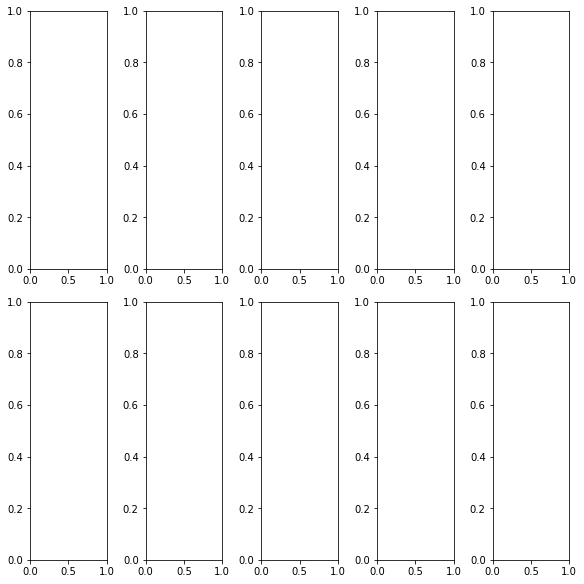

In [26]:
logs_path = '/content/drive/MyDrive/CS490/logs' # path to the tensorboard logs
gan.train(logs_path)

In [20]:
for dir in os.listdir('/content/drive/MyDrive/CS490/models/models_smoothened_data'):
  # if dir[0:10] == 'WGAN_layer' and dir != 'WGAN2022.01.26-14:29:43':
  path = os.path.join('/content/drive/MyDrive/CS490/models/models_smoothened_data', dir)
  ! rm -rf $path

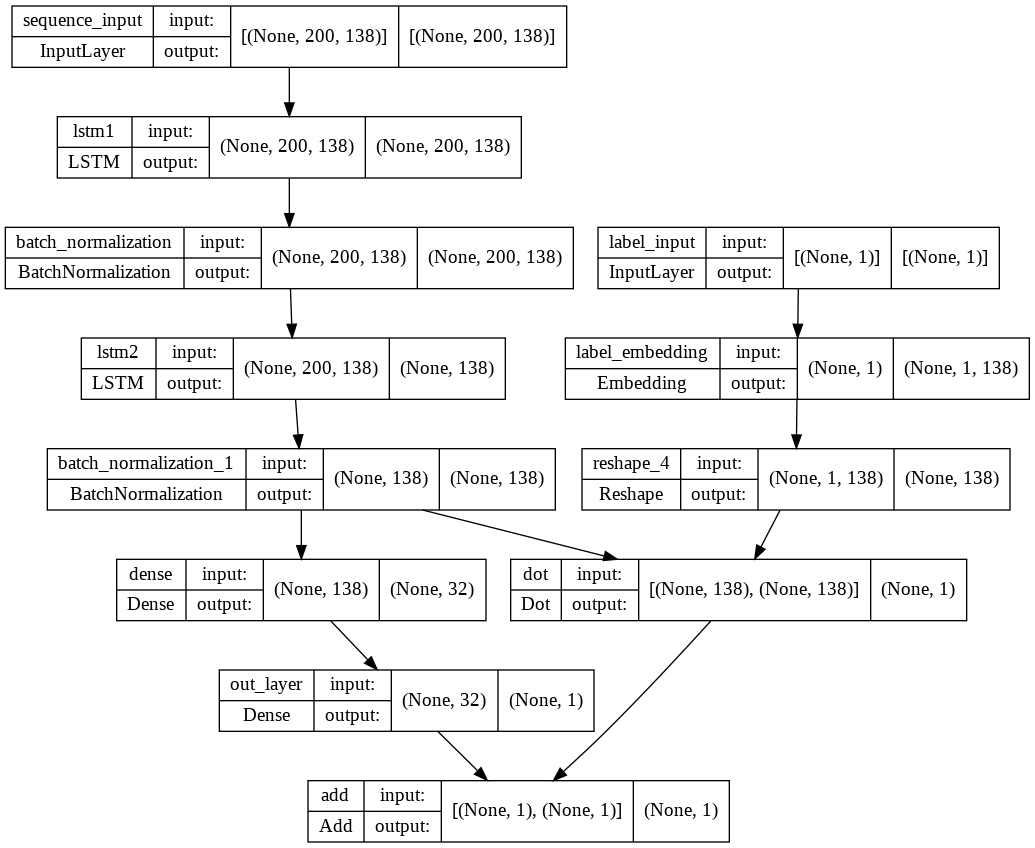

In [27]:
from keras.utils.vis_utils import plot_model
plot_model(critic, show_shapes=True, show_layer_names=True)


In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/WGAN2022.01.27-14:10:21

In [ ]:
! pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [ ]:
generator = define_generator(config)

In [ ]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 400)]        0           []                               
                                                                                                  
 lat_upsample (Dense)           (None, 13800)        5533800     ['seq_input[0][0]']              
                                                                                                  
 reshape_25 (Reshape)           (None, 200, 69)      0           ['lat_upsample[0][0]']           
                                                                                                  
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                          

In [ ]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/WGAN_norm_gen2022.02.09-21:32:41/epoch_1', 'cm.txt')) as file:
  cm = json.load(file)

In [ ]:
cm

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [5.0, 3.0, 2.0, 0.0, 5.0, 3.0],
 [4.0, 4.0, 4.0, 2.0, 4.0, 6.0],
 [1.0, 3.0, 4.0, 8.0, 1.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

<function matplotlib.pyplot.figure>

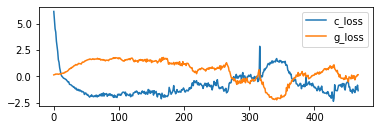

In [ ]:
Base_WGAN.plot_history(tm)

In [ ]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/WGAN_layer_norm2022.02.12-20:27:59/epoch_9', 'cm.txt')) as file:
  cm = json.load(file)